# Stellar spectra    B. LTE Line Formation  

This set of exercises was written by Robert J. Rutten and Tiago M. D. Pereira, and converted to notebook and python by Tiago M. D. Pereira and Daniel Herman, using contributions from Luc Rouppe van der Voort, Lluís Mas Ribas, and Henrik Eklund.

These three exercises treat the formation of spectral lines in the solar atmosphere assuming Local Thermodynamical Equilibrium (LTE). The topics are:
* stratification of the solar atmosphere;
* formation of the continuous solar spectrum;
* formation of Fraunhofer lines in the solar spectrum.

These exercises are a sequel to the exercises *Stellar Spectra A: Basic Line Formation*.
The two sets are independent in the sense that you don't have
to have worked through the first set to do the present set. However, various concepts needed in the present set are treated 
in the second and third exercises of the first set 
and some of the programs constructed there are useful here, 
so that it may be of interest to you to 
go through these quickly.

### Header and imports

Please don't change the cell below.

In [1]:
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy import units
from astropy import constants
from astropy.table import QTable  # To use tables with units
from astropy.modeling.blackbody import blackbody_lambda
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats
from numpy import newaxis as nax  # to simplify the many uses of this

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(7, 7 / 1.75)) # Larger figure sizes
plt.rc('font', size=12)

from scipy.integrate.quadrature import cumtrapz   # for tau integration
from scipy.ndimage import shift  # for "rotating" 3D cubes
from scipy.special import wofz   # for Voigt function

i_units = "kW m-2 sr-1 nm-1"  # More practical SI units

## 1. Stratification of the Solar Atmosphere

In this exercise you study the radial stratification
of the solar atmosphere on the basis of the standard one-dimensional (1D) FALC model by 
[Fontenla et al. (1993)](http://adsabs.harvard.edu/abs/1993ApJ...406..319F).
They derived this description of the solar photosphere and chromosphere empirically, assuming that the solar atmosphere is horizontally homogeneous ("plane parallel layers") and in hydrostatic equilibrium ("time independent").

<img src="images/avrett_pic.svg" width=250px>

*Eugene H. Avrett (born 1933)
    represents the A in the VAL (Vernazza, Avrett and Loeser) and FAL
    (Fontenla, Avrett and Loeser) sequences of standard models of the
    solar atmosphere.
    At the Center for Astrophysics (Cambridge, Mass.) he developed,
    together with programmer Rudolf Loeser, an enormous spectrum
    modeling code (called Pandora, perhaps a fitting name) which fits
    observed solar continua and lines throughout the spectrum through
    the combination of trial-and-error adjustment of the temperature
    stratification with simultaneous evaluation of the corresponding
    particle densities with great sophistication, basically performing
    complete NLTE population analysis for all key transitions in the
    solar spectrum.
    His [VALIII paper](http://adsabs.harvard.edu/abs/1981ApJS...45..635V) stands as one of the three prime solar physics
    papers of the second half of the twentieth century (with [Parker's solar wind](http://adsabs.harvard.edu/abs/1958ApJ...128..664P) prediction and [Ulrich's p-mode](http://adsabs.harvard.edu/abs/1970ApJ...162..993U) prediction).
    Photograph from the web.*

The FALC is a semi-empirical model. This means that it was not derived from first-principle physics, but by a combination of physics and empirical adjustments, so that its properties match the observations of the Sun (as much as possible). 

The FALC model is given in the `falc.dat` file. We can load the file into a useful `astropy.table.QTable` object with the correct units using the metadata in the file:

In [2]:
def read_table_units(filename):
    """
    Reads a table in a text file, formatted with column names in first row,
    and unit names on second row. Any deviation from this format will fail.
    """
    tmp = numpy.genfromtxt(filename, names=True)
    unit_names = open(filename).readlines()[1][1:].split()
    # Convert to astropy QTable to have units
    data = QTable(tmp)
    # Assign units to quantities in table, use SI units
    for key, unit in zip(data.keys(), unit_names):
        data[key].unit = unit
        data[key] = data[key].si  # We don't want to use deprecated units
    return data

In [3]:
falc = read_table_units("falc.dat")
falc

height,tau_500,colmass,temperature,v_turb,hydrogen_density,proton_density,electron_density,pressure,p_ratio,density
m,,kg / m2,K,m / s,1 / m3,1 / m3,1 / m3,N / m2,,kg / m3
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2218200.0,0.0,6.777e-05,100000.0,11730.0,5574999999999999.0,5574999999999999.0,6664999999999999.0,0.01857,0.952,1.3059999999999998e-11
2216500.0,7.696e-10,6.779e-05,95600.0,11650.0,5837999999999999.0,5836999999999999.0,6946999999999999.0,0.01857,0.95,1.3679999999999998e-11
2214890.0,1.531e-09,6.781e-05,90816.0,11560.0,6150999999999999.0,6149999999999999.0,7283999999999999.0,0.01858,0.948,1.4409999999999997e-11
2212770.0,2.597e-09,6.785e-05,83891.0,11420.0,6667999999999999.0,6666999999999999.0,7833999999999999.0,0.018590000000000002,0.945,1.562e-11
2210640.0,3.754e-09,6.788000000000001e-05,75934.0,11250.0,7380999999999999.0,7377999999999999.0,8575999999999999.0,0.018600000000000002,0.941,1.729e-11
2209570.0,4.384e-09,6.79e-05,71336.0,11140.0,7863999999999999.0,7857999999999999.0,9075999999999998.0,0.018600000000000002,0.938,1.8429999999999998e-11
2208480.0,5.065e-09,6.792e-05,66145.0,11020.0,8487999999999999.0,8475999999999999.0,9717999999999998.0,0.018609999999999998,0.935,1.989e-11
2207380.0,5.814e-09,6.794e-05,60170.0,10860.0,9333999999999998.0,9306999999999998.0,1.0589999999999998e+16,0.01862,0.931,2.1869999999999998e-11


The first column specifies the height $h$
which is the distance above $\tau_{500}=$1 where
$\tau_{500}$, given in the second column, 
is the radial optical depth in the continuum at 
$\lambda = $500 nm.
The quantity `colmass` in the third column is the 
mass of a column with cross-section of 1 m$^2$ above the given
location.  

In the photosphere ($-$100 $\leq h\leq$ 525 km) and chromosphere (525 $\leq h\leq$ 2100 km) the temperature $T$ (fourth column) has been
adjusted empirically so that the computed spectrum is in agreement
with the spatially averaged disk-centre spectrum observed from quiet 
solar areas (away from active regions). The temperature distribution
in the transition region (above $h\approx$ 2100 km, up to $T =$ 10$^5$ K) has been determined theoretically by balancing the downflow of energy from the corona through thermal conduction and diffusion against the radiative energy losses.

The microturbulence or turbulent velocity `v_turb` is a "fudge factor" to compensate for the lack of Doppler broadening in a 1D model. It has been adjusted at each height to accounts for the observed Doppler broadening of lines formed at various heights. It can compensate for the width of the lines, but cannot describe the observed line asymmetries that arise from velocities at different heights.

The total pressure $P_{\rm tot}$ is the sum of the gas pressure
$P_{\rm gas}$ and the corresponding turbulent pressure $\rho \, v_\mathrm{turb}^{2}/2$ where $\rho$
is the gas density (last column).

The table also lists the total hydrogen density $n_{\rm H}$ (`hydrogen_density`), the
free proton density $n_{\rm p}$ (`proton_density`),
and the free electron density $n_{\rm e}$ (`electron_density`).   Given the $T$ and $v_\mathrm{turb}$ distributions with height,
these number densities and other quantities 
were determined by requiring hydrostatic equilibrium and 
evaluating the ionisation balances
by solving the coupled radiative transfer 
and statistical equilibrium equations (without assuming LTE).
The adopted helium-to-hydrogen abundance ratio is 
$N_{\rm He}/N_{\rm H} = 0.1$. The relative abundances of the other elements came from [Asplund et al. (2009)](http://adsabs.harvard.edu/abs/2009ARA%26A..47..481A).


Because this is a 1D static model, it is meant to reproduce the time- and space-averaged atmosphere of the Sun. Many people take this model as a true representation of the average Sun. This is wrong. It is at best a "spectroscopically-equivalent" model of the average Sun, meaning that the radiation and spectral lines computed from this model match the time and space-averaged spectral lines observed on the Sun. The temporal and spatial inhomogeneities in the surface of the Sun mean that no 1D cut through the atmosphere is reproduced by the FALC model. To accurately describe the complex solar atmosphere, as we will see later, we need to use a 3D model.

### 1.1 FALC Temperature Stratification

Each quantity in the `QTable` can be accessed by its label, e.g. `falc['temperature']`. Here is a plot of the FALC temperature stratification in the range of temperatures where most of the radiation escapes:

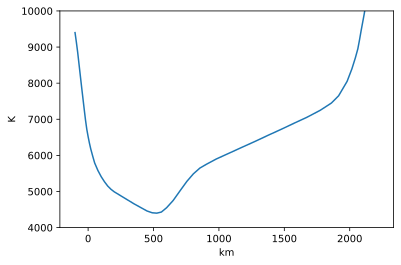

In [4]:
fig, ax = plt.subplots()
ax.plot(falc['height'].to('km'), falc['temperature'])
ax.set_ylim(4000, 10000);

### 1.2 FALC Relations

We will now study relations between various FALC
model parameters.  

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">


* Plot the total pressure $p_{\rm total}$ against the column mass $m$, both linearly and logarithmically.  You will find that they scale linearly.  Explain what assumption has caused $p_{\rm total} = c\,m$ and determine the value of the solar surface gravity $g_{\rm surface} = c$ that went into the FALC-producing code.

* [Fontenla et al. (1993)](http://adsabs.harvard.edu/abs/1993ApJ...406..319F) also assumed complete mixing, *i.e.* the same elements mix at all heights. Check this by plotting the ratio of the hydrogen mass density to the total mass density against height. Then add helium to hydrogen using their abundance and mass ratios ($N_{\rm He}/N_{\rm H} = 0.1$, $m_{\rm He} = 3.97 \, m_{\rm H}$), and estimate the fraction of the total mass density made up by the remaining elements in the model mix (the "metals").

* Create a plot of the gas pressure against height, and then overplot the product $(n_{\rm H} + n_{\rm e}) \, k_B T$. Plot the ratio of the two curves to show their differences.  Do the differences measure deviations from the ideal gas law or something else? Now add the helium density $n_{\rm He}$ to the product and enlarge the deviations. Do you see a pattern emerging? Comment on what could be missing between your calculations and the gas pressure from the model.

* Plot the ionisation fraction of hydrogen logarithmically against height. Why does this curve look like the temperature stratification plotted earlier? And why is it tilted with respect to that?

* Let us now compare the photon and particle densities. In thermodynamic equilibrium (TE) the radiation is isotropic with intensity $I_\nu = B_\nu$ and has total energy density (Stefan Boltzmann)
    \begin{equation*}
         u = \frac{1}{c} \int\!\!\!\int B_\nu \mathrm{d}\Omega \mathrm{d}\nu
           = \frac{4\sigma}{c} T^4,
      \end{equation*} so that the total photon density for isotropic TE radiation is given, with $u_\nu = \rm{d} u/\rm{d} \nu$, $T$ in K and $N_{\rm phot}$ in photons per m$^3$, by  
    \begin{equation*}
         N_{\rm phot} = \int_0^\infty \frac{u_\nu}{h\nu} \mathrm{d} \nu
            \approx 20\,T^3.
         \label{eq:20T3}
      \end{equation*} 
    This equation gives a reasonable estimate for the photon density at the deepest model location. Compute the value there and compare it to the hydrogen density. Conjecture why this equation is not valid higher up in the atmosphere. 
      
* In the upper atmosphere, the photon density there is given by $N_{\rm phot} \approx 20\,T_{\rm eff}^3/2\pi$, with $T_{\rm eff} = 5777$ K the effective solar temperature (since $\pi B(T_{\rm eff}) = \sigma T_{\rm eff}^3 = {\cal F^+} = \pi \overline{I^+}$ with ${\cal F^+}$ the emergent flux and $\overline{I^+}$ the disk-averaged emergent intensity). Compare it to the hydrogen density at the highest location in the FALC model. The medium there is insensitive to these photons (except those at the centre wavelength of the hydrogen Ly $\alpha$ line), why?

</div>

### 1.3 A 3D model atmosphere

A more realistic description of a stellar atmosphere is given by time-dependent, radiative 3D magneto-hydrodynamic (MHD) simulations. They can capture more physics, such as a realistic treatment of convection and radiation at different depths, and don't need the fudge factors such as microturbulence to make the spectra look like the observations. A proper use of these 3D models should include the temporal dimension, but for the sake of convenience and speedy calculations, we will use only a single timestep in this exercise. 

Please [download the simulation file](https://folk.uio.no/tiago/teaching/ast4310/h19/qs006024_sap_s285.fits) (132 MB) and save it in the current directory. This is one timestep of a simulation run with the [Bifrost code](https://ui.adsabs.harvard.edu/abs/2011A%26A...531A.154G/abstract), developed at [our institute](https://www.mn.uio.no/astro/english/). This particular simulation is of quiet Sun (no strong magnetic fields), and covers only a relatively small region (6 Mm x 6 Mm horizontal size), and does not include the hotter parts of transition region and corona (not relevant for this exercise). Here it is saved as a `QTable` in a special type of FITS file, so we can read it by:

In [5]:
atm3d = QTable.read("qs006024_sap_s285.fits")

In [6]:
atm3d

"temperature [256,256]","electron_density [256,256]","hydrogen_density [256,256]","velocity_z [256,256]",height,"velocity_y [256,256]","velocity_x [256,256]","pressure [256,256]"
K,1 / m3,1 / m3,m / s,m,m / s,m / s,Pa
float32,float32,float32,float32,float64,float32,float32,float32
5272.96923828125 .. 5284.5224609375,4.0828113734598656e+17 .. 4.22937661703979e+17,1.1546960635975193e+21 .. 1.1705831446017663e+21,157.57679748535156 .. 188.99781799316406,583024.0,-591.6886596679688 .. -594.4967041015625,151.15953063964844 .. 138.1940155029297,92.58880615234375 .. 94.07086181640625
5403.09130859375 .. 5411.1669921875,5.892596861260268e+17 .. 6.056246110354145e+17,1.268329059807983e+21 .. 1.2855685577065806e+21,279.1968994140625 .. 312.5419616699219,570330.6,-607.3775634765625 .. -610.0527954101562,148.22718811035156 .. 134.47979736328125,104.22808837890625 .. 105.80181884765625
5457.4619140625 .. 5460.5078125,7.130042222740767e+17 .. 7.238788733091185e+17,1.4060311220144633e+21 .. 1.4257131190234676e+21,397.9075622558594 .. 431.21435546875,557637.2000000001,-673.2451171875 .. -675.8231811523438,133.34869384765625 .. 116.03425598144531,116.7034912109375 .. 118.40267181396484
5481.47607421875 .. 5478.60009765625,8.02345177027969e+17 .. 8.032026586586808e+17,1.5645948428573422e+21 .. 1.5871253666306583e+21,493.31866455078125 .. 525.1014404296875,544943.7999999999,-847.243896484375 .. -849.96142578125,92.8567886352539 .. 66.19844055175781,130.43585205078125 .. 132.2436981201172
5437.236328125 .. 5425.58447265625,7.704930810855424e+17 .. 7.55770551670145e+17,1.7582095166500923e+21 .. 1.7849445728880238e+21,576.6238403320312 .. 605.1107177734375,532250.4,-1198.0218505859375 .. -1198.6129150390625,34.679115295410156 .. -6.235204219818115,145.38577270507812 .. 147.28074645996094
5307.6630859375 .. 5274.84521484375,6.150925743816704e+17 .. 5.789578806490563e+17,2.0056081475177378e+21 .. 2.0432271374176286e+21,639.0731811523438 .. 667.4573364257812,519557.00000000006,-1625.5244140625 .. -1612.75390625,-4.219546318054199 .. -54.43379211425781,161.87940979003906 .. 163.8760986328125
5262.65966796875 .. 5201.5166015625,5.983599315522683e+17 .. 5.33112815616e+17,2.248189193421492e+21 .. 2.3046370296759771e+21,689.3475952148438 .. 714.7586059570312,506863.6,-2112.21533203125 .. -2057.67529296875,-20.666229248046875 .. -61.263282775878906,179.88906860351562 .. 182.25088500976562
5338.16357421875 .. 5244.5224609375,7.427658717341942e+17 .. 6.196968480424591e+17,2.4565345786454176e+21 .. 2.5250317957029324e+21,740.7732543945312 .. 766.0626831054688,494160.7,-2353.88525390625 .. -2261.612060546875,-29.282499313354492 .. -28.733375549316406,199.4337615966797 .. 201.3358917236328


The file structure was built so that it looks very similar to the loaded FALC model. Many of the variable names have the same names (e.g. `temperature`, `electron_density`), but not all the quantities present in the FALC model are here. `vturb` is absent, but instead we have `velocity_z`, `velocity_y`, and `velocity_x`, respectively the velocity components in the z, y, and x axes. You will also notice that each variable is now a 3D array, e.g.:

In [7]:
atm3d['temperature'].shape

(75, 256, 256)

The array dimensions are (nz = 75, ny = 256, nx = 256). We can compare some quantities between the FALC and one column of the 3D model:

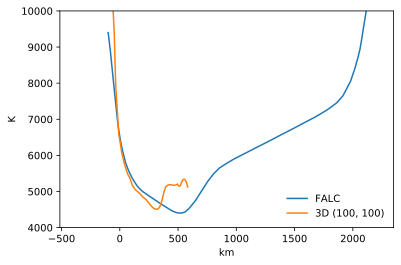

In [8]:
fig, ax = plt.subplots()
ax.plot(falc['height'].to('km'), falc['temperature'], label='FALC')
# show column (100, 100):
ax.plot(atm3d['height'].to('km'), atm3d['temperature'][:, 100, 100], label='3D (100, 100)')
ax.set_ylim(4000, 10000)
ax.legend();

We can also visualise the horizontal maps of variables at a given height using matplotlib's `imshow` function. Here for the temperature at the bottom of the atmosphere (last height point):

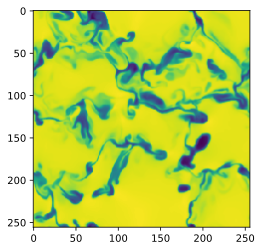

In [9]:
fig, ax = plt.subplots()
# imshow doesn't work well with units, so we need to use .value 
# (otherwise gives an error)
ax.imshow(atm3d['temperature'][-1].value);

    
### 1.4 Discussion

Comparing particle densities and column masses at the base
of the solar photosphere and at the base of the Earth's atmosphere
shows that solar light reaches the Earth's surface through
a particle density that is much higher than the particle density at 
which the solar light's escapes from the Sun ($\tau=1$). The $\tau=1$ depth is where the solar gas becomes opaque. If the Earth was irradiating the Sun, the same depth would be where the Earth's light would stop in the Sun, having passed through a much smaller amount of solar gas then it 
went through in the nearly transparent earth atmosphere (transmission
80% at $\lambda =$ 500 nm at sea level when the sky is clear, 
[Allen 1976](http://adsabs.harvard.edu/abs/1976asqu.book.....A)). 

Thus, the solar gas is much more opaque per particle than air, even
though the terrestrial air particles (molecules) are much larger than
the solar atmospheric particles (mostly hydrogen atoms and electrons).
In the first decades of the twentieth century the source of this very
large opacity was an unsolved riddle as important as the quest for the
subatomic energy source that makes the Sun shine
(for example, see the eloquent last paragraph of [Eddington's "Internal Constitution of the Stars"  1926](http://adsabs.harvard.edu/abs/1926ics..book.....E)).
That opacity is the topic of the next exercise.

## 2. Continuous Spectrum from the Solar Atmosphere

We now turn to the formation of the solar continuum radiation,
concentrating on the visible and near-infrared parts of its spectrum.

<img src="images/Subrahmanyan_Chandrasekhar.gif" width=200px>

*Subrahmanyan Chandrasekhar (1910-1995) is regarded by many as the greatest astronomer of the twentieth century. He also played an important role in the topic of this exercise, undertaking a very lengthy and difficult calculation (not a computation, no computers yet at that time!) of the bound-free and free-free extinction cross-sections of the H$^-$ ion, together with F.H. Breen. Their result, published in [Chandrasekhar & Breen (1946)](http://adsabs.harvard.edu/abs/1946ApJ...104..430C) will be duplicated in one of your graphs below. The shape of the extinction curve, 
with a peak near $\lambda =$ 1 μm and a minimum at the H$^-$ bound-free ionisation limit at $\lambda =$ 1.6 μm , reproduced the observed spectral variation of the unknown solar continuum extinction as derived already by G.F.W. Mulders at Utrecht in 1935 for $\lambda = $ 0.4- 2.5 μm. The brilliant suggestion that H$^-$ might cause this extinction, instead of the ensemble of unknown metal edges that was earlier postulated, had already been given by [Pannekoek (1930)](http://adsabs.harvard.edu/abs/1930MNRAS..91..139P), but was forgotten until it came independently from [Wildt (1939)](http://adsabs.harvard.edu/abs/1939ApJ....89..295W). The proof came with Chandrasekhar's laborious quantum mechanical evaluation and explained how the solar atmosphere can be opaque at gas densities much lower than the transparent air around us, as you found in the previous exercise. It revolutionised the understanding of cool-star atmospheres by much increasing their hydrogen-to-metals ratio and gas pressure compared with the earlier metallic-absorption modeling of Biermann, Uns&ouml;ld and Pannekoek himself. A more detailed description is found in [Hearnshaw (1986)](http://adsabs.harvard.edu/abs/1986asoh.book.....H). Photograph from Wikimedia commons.*

### 2.1 Observed Solar Continua

The file `solspect.dat` specifies the continuum radiation emitted by the sun in the wavelength range $\lambda =$ 0.2-5 μm, taken from [Allen (1976)](http://adsabs.harvard.edu/abs/1976asqu.book.....A). The file defines four different quantities as a function of wavelength, respectively the radially emergent intensity and the astrophysical flux in the solar continuum with and without smoothed lines. The units are in cgs (erg s$^{-1}$ cm$^{-2}$ μm$^{-1}$ sr$^{-1}$) with $\Delta\lambda =$ 1 μm for the spectral bandwidth. 

Let's start by reading the file and converting the units to kW m$^{-2}$ nm$^{-1}$ sr$^{-1}$:

In [10]:
i_scale = units.Quantity(1e10, unit='erg cm-2 s-1 um-1 sr-1').to(i_units)
wave_obs, f_smooth, f_cont, i_smooth, i_cont = numpy.loadtxt("solspect.dat", unpack=True)
wave_obs = wave_obs * units.um
f_smooth = f_smooth * i_scale
f_cont = f_cont * i_scale
i_smooth = i_smooth * i_scale 
i_cont = i_cont * i_scale

Your tasks will be:

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Plot the four spectral distributions together in one figure over the range $\lambda =$ 0-2 μm. Check that the continuum intensity (`i_cont`) reaches $I_\lambda^c =$ 46 kW m$^{-2}$ nm$^{-1}$ sr$^{-1}$  at $\lambda =$ 0.41 μm. Explain why the four distributions share the same units and discuss the differences between them.

* Convert these spectral distributions into values per frequency bandwidth $\Delta \nu =$ 1 Hz. Plot these also against wavelength. Check: peak $I_\nu^c =$ 4.21 nW m$^{-2}$ Hz$^{-1}$ sr$^{-1}$  at $\lambda =$ 0.80 μm.

* Try to fit a Planck function to the solar continuum intensity. What rough temperature estimate do you get?

* Invert the Planck function analytically to obtain an equation which converts an intensity distribution $I_\lambda$ into brightness temperature $T_b$ (defined by $B_\lambda(T_b) \equiv I_\lambda$). Code it as a function and use that to plot the brightness temperature of the solar continuum against wavelength. Discuss the shape of this curve. It peaks near $\lambda =$ 1.6 μm. What does that mean for the radiation escape at this wavelength?
</div>

<img src="images/gray8-6a.svg" width=700px>

*Continuous extinction coefficients $\kappa_\nu^c$ for hydrogen and helium, per neutral hydrogen atom and per unit electron pressure, for the depth $\tau_0$ = 1 (continuum optical depth at $\lambda$ = 500 nm) in the photosphere of a solar-like dwarf star. The coefficients $\kappa$ are here measured per neutral hydrogen atom in whatever state of excitation, assuming Saha-Boltzmann population partitioning, and normalised by the electron pressure $P_\mathrm{e} = n_\mathrm{e} k \, T$. The cross-sections are in units of 10$^{-26}$cm$^2$ (not cm$^2$ as specified in the $y$-axis label); stimulated emission was not included in the computation of these curves. The H$^-$ curve shows the bound-free Balmer, Paschen and Brackett edges, plus part of the Pfund edge at right. The curves do not extend beyond the Balmer edge at left where the neglected metal edges become important. Thomson scattering is also neglected. From page 140 of [Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G).*

<img src="images/krijger-ion2.svg" width=400px>

*Ionisation edges for a selection of abundant elements. The triangular symbols depict bound-free continuum edges in the form of schematic hydrogenic $\nu^{-3}$ decay functions above each ionisation threshold. The plot shows the edge distribution over ionisation energy $\chi_{1c}$ (along the bottom) or threshold wavelength (along the top) and the logarithmic product of the element abundance $A_{12} \equiv \log (n_{\rm E}/n_{\rm H} +12)$ and the bound-free cross-section per particle at threshold $\sigma/\sigma_{\rm H}$ (vertically). Thus, it shows the relative importance of the major bound-free edges throughout the spectrum. They are all at ultraviolet wavelengths and do not contribute extinction in the visible and infrared. The plus signs indicate important first-ion edges; higher ionisation stages produce edges at yet shorter wavelengths. The abundance values come from [Engvold (1977)](http://adsabs.harvard.edu/abs/1977PhyS...16...48E), abundances the ionisation energies from [Novotny (1973)](http://adsabs.harvard.edu/abs/1973itsa.book.....N), the cross-sections from the chapter by [Baschek and Scholtz (1982)](http://adsabs.harvard.edu/abs/1982lbg6.conf.....A) This Krijger production following unpublished lecture notes by E.H. Avrett, taken from the [RTSA lecture notes](http://www.staff.science.uu.nl/~rutte101/Course_notes.html).*

### 2.2 Continuous Extinction


We will assume that H$^-$(a hydrogen atom with an extra electron) is the major provider of continuous extinction in the solar atmosphere.  This is quite a good assumption
for the solar photosphere for wavelengths $\lambda > $ 0.5 μm. The second-best extinction provider are H I bound-free interactions, at only a few percent.  This may be seen in Figure above, taken from [Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G).

Below $\lambda =$ 500 nm there is heavy line crowding (not added in the figure from Gray) which acts as a quasi-continuum.  Below $\lambda =$ 365 nm the Balmer bound-free edge provides large extinction, and at yet shorter wavelengths the bound-free ionisaton edges of various metals (Al I, Mg I, Fe I, Si I, C I) provide steep extinction increase yet before the H I Lyman continuum sets in, as may be expected from the ionisation edges figure. In this exercise we will neglect these contributions by evaluating only the H$^-$ extinction and the extinction due to scattering off free electrons (Thomson scattering).

We will follow the recipe of [Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G) to calculate the H$^-$ continuous extinction, coded in the function `compute_hminus_extinction` below:

In [11]:
def compute_hminus_extinction(wavelength, temperature, electron_density):
    """
    Computes the H minus extinction cross section, both free-free and
    bound-free as per Gray (1992).
    
    Parameters
    ----------
    wavelength : astropy.units.quantity (array)
        Wavelength(s) to calculate in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
    electron_density: astropy.units.quantity (scalar or array)
        Electron density in units of per cubic length.
        
    Returns
    -------
    extinction : astropy.units.quantity (scalar or array)
        Total H- extinction in si units. 
        Shape: shape of temperature + (nwave,)
    """
    # Broadcast to allow function of temperature and wavelength
    temp = temperature[..., nax]
    wave = wavelength[nax]
    theta = 5040 * units.K / temp
    electron_pressure = electron_density[..., nax] * constants.k_B * temp
    # Compute bound-free opacity for H-, following Gray 8.11-8.12
    sigma_coeff = numpy.array([2.78701e-23, -1.39568e-18,  3.23992e-14, -4.40524e-10,
                               2.64243e-06, -1.18267e-05,  1.99654e+00])
    sigma_bf = numpy.polyval(sigma_coeff, wave.to_value('AA'))
    sigma_bf = sigma_bf * 1.e-22 * units.m ** 2
    # Set to zero above the H- ionisation limit at 1644.4 nm
    sigma_bf[wave > 1644.2 * units.nm] = 0.
    # convert into bound-free per neutral H atom assuming Saha,  Gray p156
    k_const = 4.158E-10 * units.cm ** 2 / units.dyn
    gray_saha = k_const * electron_pressure.cgs * theta ** 2.5 * 10. ** (0.754 * theta)
    kappa_bf = sigma_bf * gray_saha                    # per neutral H atom
    # correct for stimulated emission
    kappa_bf *= (1 - numpy.exp(-constants.h * constants.c / (wave * constants.k_B * temp))) 

    # Now compute free-free opacity, following Gray 8.13
    # coefficients for 4th degree polynomials in the log of wavelength (in AA)
    coeffs = numpy.array([[-0.0533464, 0.76661, -1.685, -2.2763],
                          [-0.142631, 1.99381, -9.2846, 15.2827],
                          [-0.625151, 10.6913, -67.9775, 190.266, -197.789]])
    log_wave = numpy.log10(wave.to_value('AA'))
    log_theta = numpy.log10(theta.value)
    tmp = 0
    for i in range(3):
        tmp += numpy.polyval(coeffs[i], log_wave) * (log_theta ** i)
    kappa_ff = electron_pressure * (10 ** tmp) 
    kappa_ff = kappa_ff * 1e-26 * (units.cm ** 4) / units.dyn
    return (kappa_bf + kappa_ff).si

Now lets use this function to reproduce the result of [Chandrasekhar + Breen (1946)](http://adsabs.harvard.edu/abs/1946ApJ...104..430C), computing the H$^-$ extinction for the FALC parameters at $h=$ 0 km:

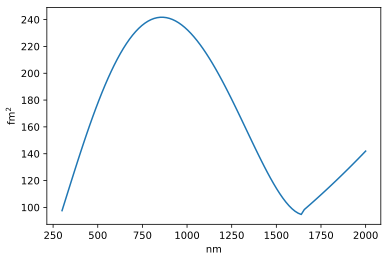

In [12]:
# Find index where h=0
index = numpy.abs(falc['height']).argmin()
wavelength = numpy.linspace(300, 2000, 100) * units.nm
temperature = falc['temperature'][index]
electron_density = falc['electron_density'][index]

# this array is [ndep, nwave]
hminus_ext = compute_hminus_extinction(wavelength, temperature, electron_density)

fig, ax = plt.subplots()
ax.plot(wavelength, hminus_ext[0].to('fm2'));

The function `compute_hminus_extinction` computes the H$^-$ extinction *cross section*, units m$^2$. To get the extinction coefficient $\alpha_\lambda$(H$^{-1}$) in units of m$^{-1}$ we need to multiply it by the number density of neutral hydrogen atoms. In the FALC model, `hydrogen_density` includes all H atoms, both neutral and ionised (protons). So we must subtract `proton_density` from `hydrogen_density` to get the number density of neutral hydrogen atoms.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Hydrogenic bound-free edges behave just as H$^-$ with maximum extinction at the ionisation limit and decay $\sim \lambda^3$ for smaller wavelengths, as indeed shown by the H$^-$ curve. The H$^-$ bound-free extinction differs strongly from this pattern. Why is it not hydrogenic although due to hydrogen?

* How should you plot this variation to make it look like the solar brightness temperature variation with wavelength? Why?

* Plot the variation of the H$^-$ extinction per m with height for $\lambda =$ 0.5 μm. This plot needs to be logarithmic in y, why?

* Now add the Thomson scattering off free electrons to the extinction per m. The Thomson cross-section per electron is the same at all wavelengths and is given by       
\begin{equation*}
        \sigma^{\rm T} = 6.648 \times 10^{-29} \rm{m}^2.
\end{equation*} 
By which height-dependent quantity do you have to multiply this number to obtain extinction per m? Overplot this contribution to the continuous extinction $\alpha_\lambda^c(h)$ in your graph and then overplot the total continuous extinction too.  Note where which effect dominates.
    
</div>

### 2.3 Optical Depth

Knowing the model atmosphere and the continuous extinction coefficient as function of height, we may now compute the corresponding optical depth scale given by:

\begin{equation*}
  \tau_\lambda(h_0) 
  \equiv -\int_\infty^{h_0} \alpha_\lambda^c \rm{d} h
              \label{eq:tau_cont}
\end{equation*}

at any height $h_0$.  Note that both FALC and the 3D model are tabulated in reverse order,
corresponding to the $-h$ direction. For the $\tau$ integration in python, the recommended approach is trapezoidal integration. In this particular case, we want a value of $\tau$ for each height point, so for every point we integrate $\alpha_\lambda$ *up to that point*, and not across the whole range of heights. This is called a *cumulative* integration. Fortunately, `scipy.integrate.quadrature` has a function `cumtrapz` that does this, so it is possible to calculate $\tau$ with a single call.

Here is an example, calculating $\tau_{500}$ for the FALC model. The model already comes with a $\tau_{500}$ scale, so we can compare it against our computation (here using only H$^-$ for extinction):

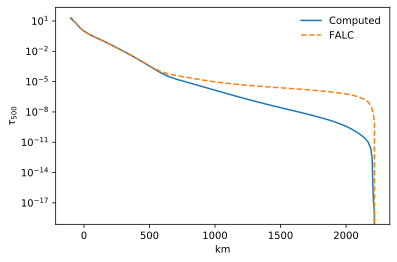

In [13]:
wave = units.Quantity([500], unit='nm')
hminus_ext = compute_hminus_extinction(wave, falc['temperature'], falc['electron_density'])[..., 0]
hminus_ext *= (falc['hydrogen_density'] - falc['proton_density']) 

tau = cumtrapz(hminus_ext, x=-falc['height'], initial=0, axis=0)

fig, ax = plt.subplots()
ax.plot(falc['height'].to('km'), tau, '-', label='Computed')
ax.plot(falc['height'].to('km'), falc['tau_500'], '--', label='FALC')
ax.set_yscale('log')
ax.set_ylabel(r'$\tau_{500}$')
ax.legend();

Note that the `initial=0` and `axis=0` arguments in `cumtrapz` are absolutely essential! The first adds a zero as first element in the array (so $\tau$ has the same dimensions as your arrays), and the second makes sure the integration happens along the first dimension (the case for our models). Also note that `cumtrapz` does not check the units, so be sure to have `hminus_ext` in m$^{-1}$ and `height` in m.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* There is something missing in the plot above. As you've done in the previous questions, compute the total continuum extinction from H$^-$ plus Thomson scattering, and re-do the $\tau$ calculation and recreate the plot.

* Now calculate $\tau_{500}$ for the 3D model (again using H$^-$ plus Thomson scattering). You should be able to run `compute_hminus_extinction` and `cumtrapz` as in the 1D case, with no loops. There is no `proton_density` available for the 3D model, so just use `hydrogen_density` in `compute_hminus_extension`. Each column in the 3D model is like a different 1D atmosphere, so each column has a different $\tau_{500}$. There are 256x256 columns in the 3D model, so it makes little sense to plot them all. Choose a small number of them and plot them in as function of height (all in one figure).

* In the 3D case $h(\tau_{500}=1)$, the height where $\tau_{500} =$ 1 (when the atmosphere becomes transparent for 500 nm), varies along the horizontal dimensions. Using your already calculated $\tau_{500}$, calculate and plot $h(\tau_{500}=1)$. For this calculation, one usually has to interpolate the $\tau_{500}$ vs $h$ curve for each line in the model, but a very quick calculation can be made by taking the model height where $\tau_{500}$ is closest to 1 (nearest neighbour) with `tau1_height = height[numpy.abs(tau - 1).argmin(axis=0)]`, replacing `height` and `tau` by the appropriate arrays. Show $h(\tau_{500}=1)$ as a 2D plot (image) and as a 3D surface plot (see below for hints on how to make this plot).
    
* ***Bonus question*** *(optional, points will be used to make up for lost points elsewhere)*: the 3D plot from the previous question will look rough because of the use of nearest neighbour. Create a smooth version of this plot by using linear interpolation for $h(\tau_{500}=1)$.
  
</div>

To make the 3D surface plot of $h(\tau_{500}=1)$, the following code is recommended. Note that you must import `Axes3D` before creating the figure:

```python
from mpl_toolkits.mplot3d import Axes3D

# x and y grids, from 0 to 6 Mm (box size), 256 points
X, Y = numpy.mgrid[0:6:256j, 0:6:256j]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# tau1_height must be a 2D array (256, 256) with the
# heights where tau = 1, preferably converted to km by .to_value('km')
ax.plot_surface(X, Y, tau1_height, cmap='magma')
```

This should give a plot such as the following (except that it should go to 6 Mm):

<img src="images/tau1_3d.png" width=500px>

If using the `inline` backend, your 3D plot will just be a static image. But if you use an interactive backend (e.g. `%matplotlib widget`) you will be able to rotate and interact with the plot.

### 2.4 Emergent intensity and height of formation

We are now ready to compute the intensity of the radiation 
that emerges from the centre of the solar disk 
(in the radial direction from the solar sphere).
It is given (assuming plane-parallel stratification) by:

\begin{equation*}
  I_\lambda = \int_0^\infty S_\lambda e^{-\tau_\lambda}
              \rm{d} \tau_\lambda.
\end{equation*}

The integrand tells us how much radiation is coming from a given layer, also called the contribution function to intensity:

\begin{equation*}
  \frac{\rm{d} I_\lambda}{\rm{d} h} =  
      S_\lambda e^{-\tau_\lambda} \alpha_\lambda
\end{equation*}

which shows the contribution of each layer to the emergent intensity.
Its weighted mean defines the "mean height of formation":

\begin{equation*}
  <\!h\!> \, \equiv \,
       \frac{\int_0^\infty h \, (\rm{d} I_\lambda/\rm{d} h) \rm{d} h}
                      {\int_0^\infty (\rm{d} I_\lambda/\rm{d} h) \rm{d} h}
     = \frac{\int_0^\infty h \, S_\lambda e^{-\tau_\lambda}
                \rm{d} \tau_\lambda}
            {\int_0^\infty S_\lambda e^{-\tau_\lambda}
              \rm{d} \tau_\lambda}.
  \label{eq:meanh}
\end{equation*}

In Local Thermodynamical Equilibrium (LTE), $S_\lambda = B_\lambda$), so we already know all the quantities. Let us find out what is the mean height of formation at 500 nm for the FALC model:

In [14]:
source_function = blackbody_lambda(500 * units.nm, falc['temperature'])
top_int = numpy.trapz(falc['height'] * source_function * numpy.exp(-tau), tau)
bottom_int = numpy.trapz(source_function * numpy.exp(-tau), tau)
hmean = top_int / bottom_int
hmean

<Quantity 3994.41798658 m>

This value is for $\tau$ computed from H$^-$ alone. If adding Thomson scattering, the number should be around 4027 m. The bottom integral is simply the emergent intensity $I_\lambda$, which we can compare to the observed value we loaded earlier:

In [15]:
intensity = bottom_int.to(i_units)
print('Observed I(500 nm) = ', i_cont[numpy.argwhere(wave_obs == 500 * units.nm)[0][0]])
print('Computed I(500 nm) = ', intensity)

Observed I(500 nm) =  40.8 kW / (m2 nm sr)
Computed I(500 nm) =  42.894211106197474 kW / (m2 nm sr)


The normalised contribution function for 500 nm can then be computed and compared with `hmean`:

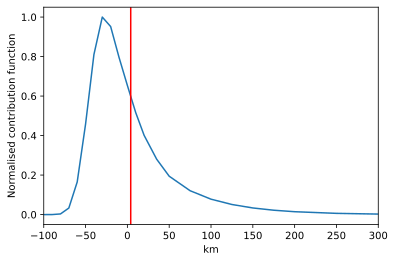

In [16]:
contrib_function = source_function * numpy.exp(-tau) * hminus_ext
contrib_function /= contrib_function.max()

fig, ax = plt.subplots()
ax.plot(falc['height'].to('km'), contrib_function)
ax.set_xlim(-100 * units.km, 300 * units.km)
ax.set_ylabel('Normalised contribution function')
ax.axvline(x=hmean, color='r');

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
 
* Re-do the plot above for the peak-normalised contribution function against height the location of `hmean` using the total extinction (H$^-$ plus Thomson scattering). 
    
* Repeat the above normalised contribution plot for $\lambda =$ 1 μm, $\lambda =$ 1.6 μm, and $\lambda =$ 5 μm (all in same plot). Discuss the changes of the contribution functions and their cause.
</div>

### 2.5 1D intensity from different directions

The solar disk-centre intensity can be calculated by using the integral expression for $S_\lambda \mathrm{e}^{-\tau_\lambda}$, which we integrate with `numpy.trapz` above. For the general case with different inclinations (given by $\mu=\cos\theta$) in a 1D plane-parallel atmosphere, the emergent intensity is given by

\begin{equation*}
    I_\lambda(0, \mu) = \int_0^\infty S_\lambda \mathrm{e}^{-\tau_\lambda/\mu}d\tau_\lambda/\mu.
\end{equation*}

We transform $\tau_\lambda \to \tau_\lambda/\mu$, meaning that inclined rays go through more material to reach the same depth in the z axis, and this increase in path length also increases the optical depth.

We can write this into a function so it's easier to use, together with a function that calculates the continuum extinction (H$^-$ plus Thomson scattering):

In [17]:
def lte_intensity_1D(wavelength, distance, temperature, extinction, mu):
    """
    Solves the radiative transfer equation assuming LTE for a single ray.
    
    Parameters
    ----------
    wavelength: astropy.units.quantity (1-D array)
        Wavelengths to calculate, in units of length.
    distance : astropy.units.quantity (1-D array)
        Distances along path of ray, in units of length. Can be different
        length than wavelength array.
    temperature: astropy.units.quantity (n-D array)
        Gas temperature in units of K or equivalent, for all points along
        the ray. Same length as distance.
    extinction: astropy.units.quantity (1D + n-D array)
        Extinction coefficient in units of inverse length, for all
        wavelengths and points along the ray. The shape of this array
        should be `(npath, nwave)`, where nwave is number of wavelength
        points, and npath number of points the ray crosses. npath
        can also be multidimensional, so the shape could be `(nz, ny, nx, nwave)`
        or `(nz, nwave)`.
    mu: float
        Cosine of angle relative to normal of surface. Use 1.0 for
        emergent intensity, mu < 1 for inclined rays.
    """
    tau = cumtrapz(extinction, x=distance, initial=0, axis=0)
    source_function = blackbody_lambda(wavelength[nax], 
                                       temperature[..., nax])
    return numpy.trapz(source_function * numpy.exp(-tau / mu), tau / mu, axis=0)


def compute_continuum(wavelength, temperature, electron_density, hydrogen_density, 
                      distance, mu):
    """
    Calculates emergent continuum intensity assuming only H- ff
    plus Thomson scattering.
    
    Parameters
    ----------
    wavelength: astropy.units.quantity (1-D array)
        Wavelengths to calculate, in units of length.
    temperature: astropy.units.quantity (n-D array)
        Gas temperature in units of K or equivalent, for all points along
        the ray. First dimension should be same length as distance.
    electron_density: astropy.units.quantity (n-D array)
        Electron density in units of m^-3 or equivalent, for all points along
        the ray. Same dimensions as temperature.
    hydrogen_density: astropy.units.quantity (n-D array)
        Hydrogen density in units of m^-3 or equivalent, for all points along
        the ray. Same dimensions as temperature.
    distance : astropy.units.quantity (1-D array)
        Distances along path of ray, in units of length. Can be different
        length than wavelength array.
    mu: float
        Cosine of angle relative to normal of surface. Use 1.0 for
        emergent intensity, mu < 1 for inclined rays.
    """
    hminus_ext = compute_hminus_extinction(wavelength, temperature, electron_density)
    hminus_ext *= hydrogen_density[..., nax]
    thomson_ext = electron_density[..., nax] * 6.648e-29 * units.m ** 2 
    total_ext = hminus_ext + thomson_ext
    intensity = lte_intensity_1D(wavelength, distance, temperature, total_ext, mu)
    return intensity

We can now use the functions above to calculate the emergent disk-centre intensity ($\mu$=1) from the FALC model, for the same wavelengths as "the observed solar continua" dataset, and compare both computed vs observed. There is no need to run a loop over wavelength, because the function takes an array of wavelengths:

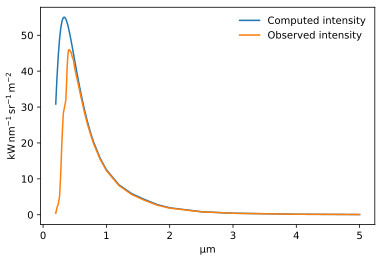

In [18]:
intensity = compute_continuum(wave_obs, falc['temperature'], falc['electron_density'], 
                              falc['hydrogen_density'] - falc['proton_density'],
                              -falc['height'], 1.0).to(i_units)

fig, ax = plt.subplots()
ax.plot(wave_obs, intensity, label='Computed intensity')
ax.plot(wave_obs, i_cont, label='Observed intensity')
ax.legend();

The discrepancy in the shorter wavelengths is because the continuum opacity there is not just H$^-$ and Thomson scattering: there are many spectral lines and other sources of opacity that decrease the continuum.

Since the function `lte_intensity_1D` can be used to compute the intensity for any inclination (in the 1D case), we can use it to calculate the flux $\cal{F}_\lambda$:

\begin{equation*}
    \mathcal{F}_\lambda = \int I_\lambda \mathrm{d}\Omega  = 2\pi\int_{-1}^1\mu I_\lambda \mathrm{d}\mu
\end{equation*}

Note that in the lecture notes the flux $\mathcal{F}_\lambda = \pi F_\lambda$, is called "flux", while $F_\lambda$ is called the "astrophysical flux". They differ only by a factor of $\pi$ for a spherical radiator. In this assignment we will only use the astrophysical flux (when we refer, for simplicity, as "flux"). For a spherical emitter, and getting only the emergent (outgoing) flux, we have:

\begin{equation*}
    F^+_\lambda = 2\int_0^1\mu I_\lambda(0, \mu)\, \mathrm{d}\mu
\end{equation*}

We can use `lte_intensity_1D` to evaluate $I_\lambda(0, \mu)$, but it cannot be evaluated at $\mu=$0. The naive way to get $F$ is simply to integrate $I_\lambda(0,\mu)$ trapezoidally over a range of angles, e.g. $\mu =$ 0.1, 0.2, ..., 1.0, but that
produces too much flux, even while ignoring the small contribution from the outer limb ($\mu=$ 0.0-0.1, $\sin\theta =$ 0.995-1), because $I_\lambda(0,\mu) \, \mu$ is a concave function ill-fitted with straight segments. This integral is therefore better evaluated with "open quadrature", an integration formula neglecting the endpoints. Classical equal-spacing recipes are the Open Newton-Cotes quadrature formulae but it is much better to use non-equidistant [Gaussian quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature), that approximate:

\begin{equation*}
    \int_{-1}^1 f(x)\, \mathrm{d}x \approx \sum_{i=1}^{n}w_i f(x_i).
\end{equation*}

In our case, $n$ is the number of rays (or directions) that we will compute $I_\lambda(0,\mu)$ for. The points $x_i$ and the weights $w_i$ are defined in the Gaussian quadrature. The last thing to note is that $x_i$ and $w_i$ are defined for an integral from $-$1 to 1, but we want from 0 to 1. So we must modify them accordingly:

\begin{eqnarray*}
    x'_i  & = &  \frac{x_i}{2} +\frac{1}{2}\\
    w'_i & = & \frac{w_i}{2} 
\end{eqnarray*}

Here is a numerical implementation to calculate the astrophysical flux from the FALC model, using $n=$3 (a reasonable choice), and comparing with the observations:

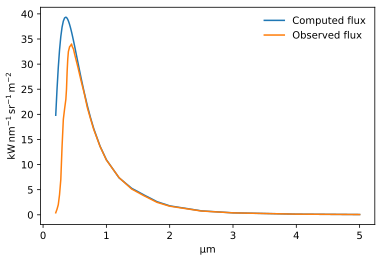

In [19]:
# Three-point Gaussian integration intensity -> flux
# rescale mu range from [-1, 1] to [0, 1]
mu_gauss = numpy.array([-0.7745966692, 0.0, 0.7745966692]) / 2 + 0.5  
weight_gauss = (numpy.array([0.5555555555, 0.8888888888, 0.5555555555]) / 2) 
imu = numpy.zeros((mu_gauss.size, wave_obs.size)) * units.Quantity(1, unit=i_units)
h_density = falc['hydrogen_density'] - falc['proton_density']

for i, mu in enumerate(mu_gauss):
    imu[i] = compute_continuum(wave_obs, falc['temperature'], 
                                falc['electron_density'], h_density, -falc['height'], mu)
    
flux = 2 * numpy.sum(weight_gauss[:, nax] * mu_gauss[:, nax] * imu , axis=0)

fig, ax = plt.subplots()
ax.plot(wave_obs, flux, label='Computed flux')
ax.plot(wave_obs, f_cont, label='Observed flux')
ax.legend();

Comparing with the previous plot, the flux is generally lower than the $\mu =$ 1 intensity, because the parts of the solar disk closer to the limb radiate less (limb darkening). This formulation of flux will become relevant at the very end of this assignment, when you will be asked to compute the flux for the Na I D spectral lines in a 3D model.

### 2.6 3D intensity from different directions

In the 3D case, we can similarly use `compute_continuum` to compute the $\mu =$ 1 intensity, replacing `falc` with `atm3d`. We don't have the proton density, so let's just assume that all hydrogen is neutral. Let's do it for 500 nm and display the image:

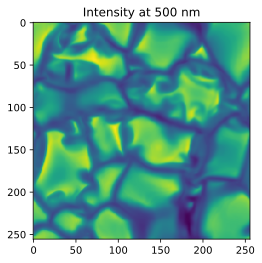

In [20]:
wavelength = numpy.array([500]) * units.nm
intensity = compute_continuum(wavelength, atm3d['temperature'], atm3d['electron_density'],
                              atm3d['hydrogen_density'], -atm3d['height'], 1.0)[..., 0]

fig, ax = plt.subplots()
ax.imshow(intensity.value)  # use data.value to avoid units giving an error
ax.set_title('Intensity at 500 nm');

We see a nice granulation pattern, which is good! The continuum intensity at 500 nm should be close to the surface intensity of the Sun. But how do we calculate inclined rays from the simulation? The function `lte_intensity_1D`, called by `compute_continuum`, is not going to work, because it assumes a semi-infinite, plane parallel atmosphere that is the same at all xy points in a given layer. So we need to actually calculate the intensity along inclined rays that go through the 3D volume. The function `lte_intensity_1D` does the integration along the first dimension of the arrays (z axis), so a simplistic view looks like this for $\mu=$1:

<img src="images/ray_straight.svg" height=300px>

This is an imaginary vertical cut through the simulation, and the boxes are the cells of simulation. For inclined rays, we need the following:

<img src="images/ray_inclined.svg" height=300px>

There are two ways to solve the radiation along inclined rays. One way is to calculate the simulation quantities (temperature, electron density, etc.) along the inclined rays, which needs many interpolations and figuring out which cell the ray intersects at which point. A much easier way is instead of tilting the rays, to tilt the simulation box instead, and use the same functions to integrate along the vertical direction. Such as this diagram:

<img src="images/box_inclined.svg" height=300px>

One thing we need to sort out is how to deal with the missing "blocks". See the arrow on right side: it must go through some volume, but what values to use there? Here we use a nice property of these simulations: they are horizontally periodic. This means that if we shift one layer of the simulation horizontally, what comes in in the missing right side is what went out of the domain on the left side. We can prove this with a simple example: we will use the `shift` function (which we imported from `scipy.ndimage`) and shift the intensity at 500 nm obtained earlier by 50 pixels in the y direction, and using the values from the other side (what is called *wrap-around extension*). Doing this, we see that the map still seems continuous (compare with earlier image of 500 nm intensity):

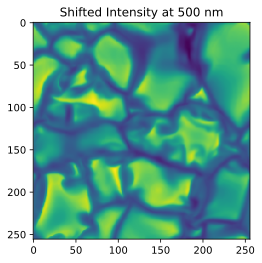

In [21]:
fig, ax = plt.subplots()
ax.imshow(shift(intensity.value, (50, 0), mode='wrap'), cmap='viridis')
ax.set_title('Shifted Intensity at 500 nm');

If we shift instead a subset of the image (no longer horizontally periodic) we see that it is no longer smooth:

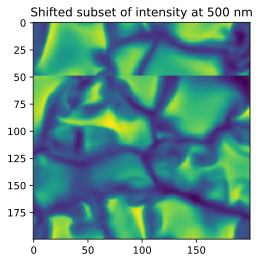

In [22]:
fig, ax = plt.subplots()
ax.imshow(shift(intensity[:200, :200].value, (50, 0), mode='wrap'), cmap='viridis')
ax.set_title('Shifted subset of intensity at 500 nm');

So we can use the `shift` function to "tilt" or the 3D arrays from the simulation, layer by layer.  We keep the bottom layer fixed, but shift each plane to account for the rotation and adjust the spacing between the planes (`height` array), because on the inclined version the rays will go through a distance of $z\times\mu$. The following function does this tilting and returns a new `QTable`:

In [23]:
def shift_simulation(data, mu):
    """
    Shifts (or translates) a 3D horizontally periodic simulation according to an
    inclination angle given by mu = cos(angle). 
    
    Parameters
    ----------
    data : astropy.table.table.QTable
        Data from a 3D simulation in QTable format. Should have 
        several 3D variables plus a single 1D variable called "height",
        and some extra metadata.
    mu : float
        Cosine of inclination angle.
    """
    data_shifted = data.copy()
    pixel_size = data.meta['XPIX_KM'] * units.km  # horizontal pixel size
    angle = numpy.arccos(mu)
    shift_pix = data['height'] * numpy.tan(angle) / pixel_size
    data_shifted['height'] *= mu
    ndep = len(data)
    
    for var in data_shifted.keys():
        if data[var].ndim != 3:
            continue
        for i in range(ndep):
            # shift only in x direction:
            data_shifted[var][i] = (shift(data[var][i], 
                                    (shift_pix[i], 0), mode='wrap') *
                                    data[var].unit)
    return data_shifted

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
 
* Compute the continuous intensity at 500 nm from the simulation at two viewing angles: $\mu$=0.4 and 0.2 (about 66° and 78°). Plot both intensity maps with identical physical sizes in the x and y axes.
    
* In 3D space a rotation can be along two angles. Here $\mu$ represents a rotation along the polar angle, but one can also do a rotation around an azimuthal angle. How would you rotate the simulation cubes by an azimuthal angle? (Think multiples of 90° rotations, and it becomes much easier.)
    
*Hints:* you can use `compute_continuum` but need to use $\mu =$ 1, and instead rotate the simulation with `shift_simulation`. By tilting the simulation you will obtain intensity maps that have the same number of pixels (256 x 256), but the rotation compresses the physical size by $\mu$ along the direction that was tilted. You will need to account for that in your plotting. Your result should look like the image below:  
</div>

<img src="images/inclined_Icont.svg" height=300px>



### 2.7 Discussion

You have succeeded in explaining the solar continuum at visible and
infrared wavelengths as largely due to H$^-$ extinction.  This is what [Chandrasekhar & Breen (1946)](http://adsabs.harvard.edu/abs/1946ApJ...104..430C)
accomplished.
The bound-free contribution from H I is small since the required
populations of $n=$ 3 (Paschen continuum) and $n=$ 4 (Brackett
continuum) are small (Boltzmann partitioning).
Other elements do not contribute continuous extinction in the visible
and infrared because their major bound-free edges are all in the
ultraviolet.

The large opacity of the solar photosphere is therefore due to the
combination of abundant neutral hydrogen atoms, the presence
of free electrons (that come mostly from other particle species with
lower ionisation energy), and the large polarization of the
simple electron-proton combination which produces a
large cross-section for Coulomb interactions between hydrogen atoms
and free electrons.  
There are no free electrons in our own atmosphere and the molecules
making up the air around us
possess much better Coulomb shielding; terrestrial air is therefore far less
opaque at visible wavelengths than the solar gas.
In the infrared, air is similarly transparant in some spectral windows 
correspondig to energy bands in which the molecules can't rotate or vibrate.

In general, radiative transfer in stellar atmospheres is a difficult
subject because in our daily physical experience, gases ought to be
transparent.  Even though stars are fully gaseous, they are far
from transparent.  H$^-$ extinction makes even the 
atmospheres of cool stars less transparent 
than what we would expect for gases so tenuous.

A final note: while LTE is an excellent assumption
for H$^-$ bound-free processes and exactly valid (as long as the
Maxwell distribution holds) for H$^-$ free-free processes, it is
not at all valid for Thomson scattering.  The process source function
for purely coherent (monochromatic) scattering is not given by
$B_\lambda(T)$ but by the angle-averaged intensity 
$J_\lambda \equiv (1/4\pi) \int I_\lambda \rm{d} \Omega$.  Obtaining 
$J_\lambda$ from such an integration requires knowledge of the 
intensity $I_\lambda(h,\theta, \varphi)$ locally and in all directions.

## 3. Spectral Lines from the Solar Atmosphere

<img src="images/unsold.svg">

*Albrecht O.J. Uns&ouml;ld (1905-1995) was the first, in 1941 at Kiel, to study stellar composition ("abundance analysis")  in the detail permitted by proper physical understanding of line formation (for the B0 dwarf $\tau$ Scorpii, using spectrograms taken during a six-month visit to the US just before the second world war).  He used the so-called "coarse" analysis based on Minnaert's curve of growth for a Schuster-Schwarzschild single "reversing layer" as in the third exercise of "Stellar Spectra A: Basic Line Formation".  Later, he led a school of astrophysicists at Kiel in "fine analysis", combining LTE line formation with non-grey stratified atmosphere modeling just as you do in this exercise.  The technique was developed by L.H. Aller, C. de Jager and others in the fifties, and has dominated stellar abundance analysis throughout the second half of the twentieth century. He spelled out its physical basis in great detail in his ["Physik der Sternatmosph&auml;ren"](http://adsabs.harvard.edu/abs/1955psmb.book.....U). Portrait copied from [Hearnshaw (1986)](http://adsabs.harvard.edu/abs/1986asoh.book.....H).*

### 3.1 The Na I D lines

The Na I D lines are a pair of strong spectral lines, among the strongest in the solar spectrum. They were named D$_1$ and D$_2$ by [Joseph von Fraunhofer](https://en.wikipedia.org/wiki/Fraunhofer_lines), with the letter D coming from his original classification. In this exercise we will compute the Na I D line profiles using the FALC and the 3D model atmospheres, and also compare with observations.

The file `int_nad.dat` contains spectra of the lines (and the surrounding region) taken from the atlas of [Wallace et al. (1998)](https://ui.adsabs.harvard.edu/abs/1998assp.book.....W), observed with the Fourier Transform Spectrometer (FTS) at the [McMath-Pierce solar telescope](https://en.wikipedia.org/wiki/McMath%E2%80%93Pierce_solar_telescope) (still the largest solar telescope in the world, although mostly retired now) at [Kitt Peak](https://en.wikipedia.org/wiki/Kitt_Peak_National_Observatory). The [FTS](https://www.noao.edu/noao/staff/plymate/fts/aboutFTS.html) remains the highest spectral resolution spectrograph in astrophysics (resolving power $R > $ 10$^6$). The spectra in the file are for disk-centre ($\mu =$ 1) intensity, and are normalised by the continuum intensity. 

The file contains wavenumbers (first column), intensities (third column), and other quantities we don't need. We can load it, convert wavenumbers to wavelengths and assign units by doing the following:

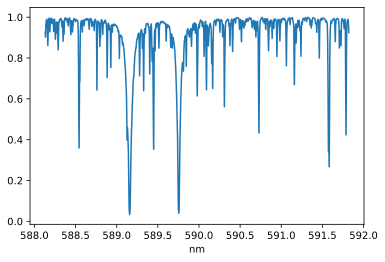

In [24]:
wnum, _, sp_obs, _ = numpy.loadtxt("int_nad.dat", unpack=True)
wnum = wnum / units.cm
wave = wnum.to("nm", equivalencies=units.spectral())

fig, ax = plt.subplots()
ax.plot(wave, sp_obs);

The Na I D$_1$ and D$_2$ are the two strongest lines. The line properties are listed in the table below.


|                  | Na I D$_1$ | Na I D$_2$ |
|------------------|-----------:|-----------:|
| Air wavelength (nm)  | 589.755         | 589.158  |
| Lower level      |  3s\,2S$_{1/2}$ | 3s\,2S$_{1/2}$ |
| Upper level      |  3p\,2P$^{\rm o}_{1/2}$ | 3p\,2P$^{\rm o}_{3/2}$ |
| $\chi_{1,l}$ (aJ)| 0     | 0      |
| $\chi_{1,u}$ (aJ)| 0.3368| 0.3371 |
|   $g_l$          | 2     | 2      |
|   $g_u$          | 2     | 4      |
| $f_{lu}$         | 0.318 | 0.631  |

They are resonance lines of sodium and therefore share the lower level. The Na ionisation energy of first ionisation is 0.823 aJ, and subsequent ionisation energies are much higher (7.58 aJ and 11.48 aJ).

### 3.2 LTE Line Formation

We will now compute the solar Na I D$_1$ line for different atmospheres assuming LTE for the line source function. Since LTE holds already for the continuum processes at these
wavelengths (being dominated by H$^-$ bound-free transitions),
the assumption of LTE line formation implies that you can simply set
$S_\lambda^l = S_\lambda^c = S_\lambda^{\rm total} = B_\lambda(T)$. What remains is first to evaluate the line extinction as a function of
height and wavelength, and then to add that to the continuous extinction
calculated in the previous exercise. We need to calculate the intensity for the wavelengths of the Na I D$_1$ profile.

The monochromatic line extinction per m path length for a bound-bound transition between a lower level $l$  and an upper level $u$ is given by (in SI units):
\begin{equation*}
\alpha_\lambda^l = \frac{e^2}{4\varepsilon_0 m_ec}\frac{\lambda^2}{c}\frac{n_l^\mathrm{LTE}}{N_E}N_H A_E f_{lu}\frac{H(a, v)}{\Delta\lambda_D}\left[1 - \mathrm{e}^{-hc/\lambda k_B T}\right]
\end{equation*}

This is a slightly modified version of $\alpha_\nu$ from the lecture notes (Section 5.4, page 62): the differences are that we explicitly write the broadening profile as the Voigt profile $V(a, \lambda)\equiv H(a, v)/\Delta\lambda_D$, a factor of $\lambda^2 / c$ from converting the frequency profile to wavelength profile, and writing the lower-level populations $n_l$ as a relative element population, hydrogen density, and element abundance.

We will now proceed to calculate all the components of the equation above.

#### 3.2.1 Level populations

The LTE population fraction $n_l^{\rm LTE}/N_\rm{E}$ (lower level
population scaled by the total element population) is given by the
combined Saha and Boltzmann distributions

\begin{eqnarray*}
   U_r 
   &\equiv& \sum_s g_{r,s} e^{-\chi_{r,s}/kT}
             \label{eq:parfunc} \\
   \frac{n_{r,s}}{N_r}
   &=& \frac{g_{r,s}}{U_r} e^{-\chi_{r,s}/kT}
             \label{eq:Boltzmann} \\
   \frac{N_{r+1}}{N_r}
   &=& \frac{1}{N_\rm{e}} \frac{2U_{r+1}}{U_r}
       \left(\frac{2 \pi m_\rm{e} kT}{h^2}\right)^{3/2} 
       e^{-\chi_r/kT},
            \label{eq:Saha}
\end{eqnarray*}

where $s$ is the level counter and $r$ the ionisation stage
counter.

Instead of calculating the population fractions by hand, we can make use of the `Atom` class developed for SSA. Please use the class below for your calculations. It is a slightly modified version of the SSA class, but improved to work better with 3D arrays.

In [25]:
class Atom:
    """
    Reads atomic data, calculates level populations according to Boltzmann's law,
    and ionisation fractions according to Saha's law.
    """
    
    def __init__(self, atomfile=None):
        """
        Parameters
        ----------
        atomfile : string, optional
            Name of file with atomic data. If not present, atomic data needs
            to be loaded with the .read_atom method.
        """
        self.loaded = False
        if atomfile:
            self.read_atom(atomfile)
        
    def read_atom(self, filename):
        """
        Reads atom structure from text file.
        
        Parameters
        ----------
        filename: string
            Name of file with atomic data.
        """
        tmp = numpy.loadtxt(filename, unpack=True)
        self.n_stages = int(tmp[2].max()) + 1
        # Get maximum number of levels in any stage
        self.max_levels = 0
        for i in range(self.n_stages):
            self.max_levels = max(self.max_levels, (tmp[2] == i).sum())
        # Populate level energies and statistical weights
        # Use a square array filled with NaNs for non-existing levels
        chi = numpy.empty((self.n_stages, self.max_levels))
        chi.fill(numpy.nan)
        self.g = numpy.copy(chi)
        for i in range(self.n_stages):
            nlevels = (tmp[2] == i).sum()
            chi[i, :nlevels] = tmp[0][tmp[2] == i]
            self.g[i, :nlevels] = tmp[1][tmp[2] == i]
        # Put units, convert from cm-1 to Joule
        chi = (chi / units.cm).to('aJ', equivalencies=units.spectral())
        # Save ionisation energies, saved as energy of first level in each stage
        self.chi_ion = chi[:, 0].copy()
        # Save level energies relative to ground level in each stage
        self.chi = chi - self.chi_ion[:, nax]
        self.loaded = True

    def compute_partition_function(self, temperature):
        """
        Computes partition functions using the atomic level energies and
        statistical weights.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
            
        Returns
        -------
        pfunc : astropy.units.quantity (array)
            Partition function. Shape is (nlevels,) + temperature.shape.
        """
        if not self.loaded:
            raise ValueError("Missing atom structure, please load atom with read_atom()")
        temp = temperature.T[..., nax, nax]  # to allow broadcast
        return numpy.nansum(self.g.T * numpy.exp(-self.chi.T / constants.k_B / temp), axis=-2).T
    
    def compute_excitation(self, temperature):
        """
        Computes the level populations relative to the ground state,
        according to the Boltzmann law.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        
        Returns
        -------
        exc : astropy.units.quantity (array)
            Populations of excited states relative to total number of species.
            Shape is (nstages, nlevels) + temperature.shape.
        """
        pfunc = self.compute_partition_function(temperature)
        temp = temperature.T[..., nax, nax]
        # relative to total number of atoms in this stage
        g_ratio = self.g.T / pfunc[:, nax].T
        result = (g_ratio * numpy.exp(-self.chi.T / (constants.k_B * temp))).T
        return result
    
    def compute_ionisation(self, temperature, electron_density):
        """
        Computes ionisation fractions according to the Saha law.
        IMPORTANT: changed from SSA: now takes electron density 
                   instead of electron pressure.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_density: astropy.units.quantity (scalar)
            Electron density in units of m^-3 or equivalent.

        Returns
        -------
        ion_frac : astropy.units.quantity (array)
            Ionisation fraction relative to total number of species.
            Shape is (nstages,) + temperature.shape.
        """
        partition_function = self.compute_partition_function(temperature)
        saha_const = ((2 * numpy.pi * constants.m_e * constants.k_B * 
                       temperature.astype('d')) / (constants.h ** 2)) ** (3 / 2)
        nstage = numpy.zeros_like(partition_function) / units.m ** 3
        nstage[0] += 1. / units.m ** 3
        # Below we use the values for ionisation energies that are saved
        # in the first index of each excited state: self.chi[r + 1, 0]
        for r in range(self.n_stages - 1):
            nstage[r + 1] = (nstage[r] / electron_density * 2 * saha_const *
                             partition_function[r + 1] / partition_function[r] * 
                             numpy.exp(-self.chi_ion[r + 1, nax] / 
                                       (constants.k_B * temperature[nax])))
        # nansum is needed because the last stage might have only one level
        # (only ionisation potential)
        return nstage / numpy.nansum(nstage, axis=0)

    def compute_populations(self, temperature, electron_density):
        """
        Computes relative level populations for all levels and all
        ionisation stages using the Bolzmann and Saha laws.
        IMPORTANT: changed from SSA: now takes electron density 
                   instead of electron pressure.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_density: astropy.units.quantity (scalar)
            Electron density in units of m^-3 or equivalent.
            
        Returns
        -------
        pop_frac : astropy.units.quantity (array)
            Population of different levels relative to total number of species.
            Shape is (nstages, nlevels) + temperature.shape.
        """
        return (self.compute_excitation(temperature) * 
                self.compute_ionisation(temperature, electron_density)[:, nax])

In this directory you can also find a model atom of Na I (plus a single state of Na II), called `NaI_atom.txt`. Have a look at the model atom file. It is very simple and has only the Na I D lines, plus the first state of Na II to calculate the partition function. The reason for this simplicity is to save on needless calculations, since the `Atom` class computes the populations for *all* levels and states, doing that for many points will become tedious and unnecessary. You can load it as before in SSA:

In [26]:
na_atom = Atom("NaI_atom.txt")

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* ***Bonus question*** *(optional, points will be used to make up for lost points elsewhere)*: calculating the partition function relies on having the level energies for several excited states, but in our simple atom we have only two excited states in neutral sodium. Check how far we are from a better partition function by comparing with the recipe given below at 5000 K and 6000 K.
    
* ***Bonus question*** *(optional, points will be used to make up for lost points elsewhere)*: modify the `Atom` class to use the partition function for Na I given by the recipe below, instead of calculating it from the model atom. Use this class for all later calculations. *Hint*: since you are modifying the class, you may as well prevent it from computing the populations of Na II, since these will not be used and will take up twice as much memory.
    
    
[Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G) gives the following recipe for the Na I partition function: $\log U_{\rm Na\,I}(T) \approx c_0 + c_1 \log \theta + c_2 \log^2 \theta + c_3 \log^3 \theta + c_4 \log^4 \theta $ with $\theta \equiv 5040./T$ and $c_0 = 0.30955$, $c_1=-0.17778$,    $c_2=1.10594$, $c_3=-2.42847$ and $c_4=1.70721$. In the 2005 version of the book, these fits were replaced by a table, which you can use if you prefer.
</div>

#### 3.2.2 Line Broadening

The Voigt function  $H(a,v)$ describes the extinction profile shape and is defined by:

\begin{eqnarray*}
   H(a,v) &\equiv& \frac{a}{\pi} \int_{-\infty}^{+\infty}
            \frac{e^{-y^2}}{(v - y)^2 + a^2} \rm{d} y
                          \label{eq:Voigt} \\[1ex]
   y &=& \frac{v_\mathrm{los}}{c} \frac{\lambda_0}{\Delta \lambda_{\rm D}}\\
   v &=& \frac{\lambda-\lambda_0}{\Delta \lambda_{\rm D}}   
                          \label{eq:Voigtv} \\
   a &=& \frac{\lambda^2}{4\pi c}\frac{\gamma}{\Delta \lambda_{\rm D}},
                          \label{eq:Voigta} 
\end{eqnarray*}

where $v_\mathrm{los}$ is the velocity along the line of sight and $a$ the damping parameter. The Doppler width $\Delta \lambda_{\rm D}$ is not only set by the thermal broadening but in the 1D case it includes also the microturbulent "fudge parameter"  $v_\mathrm{turb}$ through defining it as:

\begin{equation*}
   \Delta \lambda_{\rm D} 
      \equiv \frac{\lambda_0}{c} \sqrt{\frac{2kT}{m} + v_\mathrm{turb}^2}
    \label{eq:microturbulence}
\end{equation*}
where $m$ is the mass of the line-causing particle in kilograms,
for sodium $m_{\rm Na} = 22.99 \times 1.6605 \times 10^{-27}$ kg.

The damping parameter $a$ may be approximated by taking only Van der Waals broadening into account. Figure 11.6 of [Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G) shows this by comparing Van der Waals broadening with natural broadening and Stark broadening for the Na I D lines throughout a solar radiative-equilibrium model. However, since the model atmospheres reach higher we might also add in natural broadening width:

\begin{equation*}
   \gamma_{\rm rad} = A_{ul} = 
   6.67 \times 10^{13} \frac{g_l}{g_u} \, \frac{f_{lu}}{\lambda^2}
            \;\;\;\left[\mathrm{s}^{-1}\right],
      \label{eq:gamrad}
\end{equation*}
for $\lambda$ in nm.

The classical evaluation recipe of Van der Waals broadening by [Uns&ouml;ld (1955)](http://adsabs.harvard.edu/abs/1955psmb.book.....U)
is (cf. [Warner (1967)](http://adsabs.harvard.edu/abs/1967MNRAS.136..381W)):

\begin{equation*}
     \log \gamma_{\rm vdW} \approx 6.33
                     + 0.4 \log \left(\overline{r_u^2}-\overline{r_l^2}\right)
                     + \log P_g - 0.7 \log T,
    \label{eq:vanderWaals}
\end{equation*}

where the mean square radii $\overline{r^2}$
of the upper and lower level are usually estimated from the 
hydrogenic approximation of [Bates and Damgaard (1949)](http://adsabs.harvard.edu/abs/1948ApJ...107..383B):

\begin{equation*}
    \overline{r^2} = \frac{{n^\ast}^2}{2 Z^2}
            \left( 5 {n^\ast}^2 +1 - 3l(l+1)\right)
    \label{eq:Bates-Damgaard}
\end{equation*}

with $\overline{r^2}$ measured in atomic units,
$l$ the angular quantum number of the level and
$n^\ast$ its effective (hydrogen-like) principal quantum number 
given by

\begin{equation*}
   {n^\ast}^2 = R \frac{Z^2}{E_\infty - E_n}
    \label{eq:effectiven}
\end{equation*}

in which the Rydberg constant $R=$ 2.18 aJ, $Z$ is the ionisation stage ($Z=$ 1 for Na I, $Z=$ 2 for Na II, etc)
and $E_\infty - E_n$ is the ionisation energy from the level
(compute the excitation energy of the upper level from the
 line-centre wavenumber).
The common Na I D$_1$ and Na I D$_2$ lower level (3s\,2S$_{1/2}$) has $l=0$, the upper levels (3p\,$^2$P$^{^\rm o}_{1/2}$ and  3p\,$^2$P$^{^\rm o}_{3/2}$) have $l=1$. 

Because $\gamma_{\rm rad}$ and $\gamma_{\rm vdW}$ are both associated with a Lorentzian profile, we can just sum them into $\gamma$ and replace that in the equation for the damping $a$:

\begin{equation*}
   \gamma = \gamma_{\rm rad} + \gamma_{\rm vdW}
\end{equation*}

See below for functions to calculate these quantities. Remember that, as in SSA, the `voigt` function  computes the profile $H(a,v)$.

In [27]:
def voigt(gamma, x):
    """
    Computes the Voigt function.
    """
    z = (x + 1j * gamma)
    return wofz(z).real


def compute_doppler_width(wave0, temperature, mass, vturb):
    """
    Computes the Doppler width.
    
    Parameters
    ----------
    wave0: astropy.units.quantity (scalar)
        Rest wavelength of the bound-bound transition, in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Temperature(s) where to calculate the Doppler width.
    mass: astropy.units.quantity (scalar)
        Mass of the atomic species, in units of mass.
    vturb: astropy.units.quantity (scalar or array)
        Turbulent velocity in units of length per time. If array, should be
        the same shape as temperature.
        
    Returns
    -------
    doppler_width: astropy.units.quantity (scalar or array)
        Doppler width in units of length. Same shape as temperature.
    """
    return wave0 / constants.c * numpy.sqrt(2 * constants.k_B * 
                                            temperature / mass + vturb ** 2)


def compute_gamma_natural(wave, g_ratio, f_value):
    """
    Computes the natural line damping parameter for a bound-bound transition.
        
    Parameters
    ----------
    wave: astropy.units.quantity (scalar or array)
        Wavelength to calculate.
    g_ratio: float
        Ratio between statistical weights of lower and upper levels (gl / gu)
    f_value: float
        Transition f value.

    Returns
    -------
    gamma - astropy.units.quantity (scalar or array)
        Damping parameter in units of s^-1.
    """
    return 6.6e13 * g_ratio * f_value / wave.to_value('nm') ** 2 / units.s


def compute_gamma_vdW(temperature, gas_pressure, l_l, l_u, stage, e_ion_l, e_ion_u):
    """
    Computes the van der Waals damping parameter for a bound-bound transition.
        
    Parameters
    ----------
    wave: astropy.units.quantity (scalar or array)
        Wavelength to calculate.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
    gas_pressure: astropy.units.quantity (scalar)
        Gas pressure in units of Pa or equivalent. Same shape as temperature.
    l_l: integer
        Angular quantum number of lower level
    l_u: integer
        Angular quantum number of upper level
    stage: integer
        Ionisation stage, where 1 is neutral, 2 first ionised, and so on.
    e_ion_l: astropy.units.quantity (scalar)
        Ionisation energy from the lower level of the transition.
    e_ion_u: astropy.units.quantity (scalar)
        Ionisation energy from the upper level of the transition.
    """
    # Rydberg constant in energy units
    ryd = constants.Ryd.to("aJ", equivalencies=units.spectral())
    
    # effective principal quantum number
    def _compute_r_square(l_number, e_ion):
        ryd = constants.Ryd.to("eV", equivalencies=units.spectral())
        n_star = ryd * stage ** 2 / e_ion
        r_square = (n_star / (2 * stage ** 2) * 
                    (5 * n_star + 1 - 3 * l_number * (l_number + 1)))
        return r_square
    
    # From Unsold recipe
    rdiff = _compute_r_square(l_u, e_ion_u) - _compute_r_square(l_l, e_ion_l) 
    log_gamma = (6.33 + 0.4 * numpy.log10(rdiff.value) + 
                 numpy.log10(gas_pressure.cgs.value) - 0.7 * numpy.log10(temperature.value))
    return 10 ** log_gamma / units.s

### 3.2.3 Putting it all together

We now have all the ingredients to compute the Na I D line extinction and add it to the continuum extinction to compute the line profile. Below we put it all together to compute the Na I D line from the FALC model atmosphere, for two inclinations: $\mu =$ 1 and 0.2.

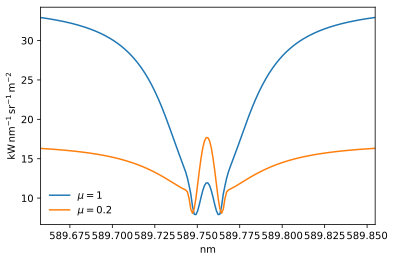

In [28]:
na_atom = Atom("NaI_atom.txt")

# Properties of Na
abund_na = 1.7378e-6  # From Asplund et al. (2009)
mass_Na = 22.99 * constants.u

# Properties of Na I D1
wave_NaD1 = na_atom.chi[0,1].to('nm', equivalencies=units.spectral())
#wave_NaD1 = 589.594 * units.nm
f_value = 0.318

# Calculate the profile for 200 wavelength points around Na I D
waves_line = numpy.linspace(-0.1, 0.1, 200) * units.nm + wave_NaD1

doppler_width = compute_doppler_width(wave_NaD1, falc['temperature'], mass_Na, falc['v_turb'])

gamma_vdw = compute_gamma_vdW(falc['temperature'], falc['pressure'], l_l=0, l_u=1, 
                              stage=1, e_ion_l=5.139 * units.eV, 
                              e_ion_u=(5.139 - 2.10285) * units.eV)

gamma_natural = compute_gamma_natural(waves_line, g_ratio=1, f_value=0.318)

damping = (waves_line ** 2 / (4 * numpy.pi * constants.c * doppler_width[:, nax]) * 
           (gamma_natural + gamma_vdw[:, nax])) 

# Dimensionless velocities in units of Doppler width to go to Voigt function
v = ((waves_line - wave_NaD1) / doppler_width[:, nax]).si
profile = voigt(damping, v)

# Constants in the formula for alpha
alpha_const = constants.e.si ** 2 / (4 * constants.eps0 * constants.m_e * constants.c ** 2)

# Stimulated emission
stim = (1 - numpy.exp(-constants.h * constants.c / 
                      (waves_line * constants.k_B * falc['temperature'][..., nax])))

# Lower level populations, neutral stage, ground level
pops = na_atom.compute_populations(falc['temperature'], falc['electron_density'])[0, 0]
pops = pops * abund_na * falc['hydrogen_density']

# line extinction
extinction_NaID = (alpha_const * (waves_line ** 2) * pops[..., nax] * 
                   f_value * profile / doppler_width[...,  nax] * stim)

# continuum extinction
hminus_ext = compute_hminus_extinction(waves_line, falc['temperature'],
                                       falc['electron_density'])
hminus_ext *= (falc['hydrogen_density'] - falc['proton_density'])[..., nax]
thomson_ext = 6.648e-29 * units.m ** 2 * falc['electron_density'][..., nax]

total_ext = hminus_ext.si + thomson_ext.si + extinction_NaID.si

# compute intensity
intensity = lte_intensity_1D(waves_line, -falc['height'], falc['temperature'], total_ext, 1.0)
intensity_limb = lte_intensity_1D(waves_line, -falc['height'], falc['temperature'], total_ext, .2)

fig, ax = plt.subplots()
ax.plot(waves_line, intensity.to(i_units), label=r'$\mu=1$')
ax.plot(waves_line, intensity_limb.to(i_units), label=r'$\mu=0.2$')
ax.set_xlim(waves_line[2], waves_line[-2])
ax.legend();

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Organise the code above into a function or class that computes the Na I D$_1$ line profile for a given 1D model atmosphere and $\mu$. It is logical to split some of the code into sub-functions or methods (e.g. profile, populations, continuum extinction, integration).
    
* Plot the normalised line profile for Na I D$_1$ (disk-centre intensity) from the FALC model against the observations we loaded earlier in 3.1 and discuss the differences. Explain why your computed profile has a line-centre reversal.
    
* Compute the Na I D$_1$ line profiles from the 3D model for $\mu =$ 1. You will need to modify the code above, both to add physics and to avoid filling up the memory of your computer (see hints below). Compute the spatially-averaged line profile, and plot it against a selection of line profiles from different xy points of the simulation (e.g. every 10th point in the y and x directions), so you can see the spatial variations between line profiles).
    
* After you compute the intensities in the point above, you should obtain an array whose shape is `(nwave, nx, ny)`. Plot a spectrogram along one row or column of the simulation (e.g. `intensity_3d[:, 0]`), where the x axis is wavelength and the y axis is physical distance in Mm.
    
* Compute the $\mu=$ 1 spectra from the FALC model using no microturbulence and plot it against the spatially-averaged $\mu=$ 1 spectra from the 3D model (where motion broadening happens naturally). What can you conclude?
    
* Compute the Na I D$_1$ line profiles from the 3D model for $\mu =$ 0.2 and an azimuthal angle of zero. The procedure is mostly identical to the $\mu =$ 1 case, but in addition to tilting the simulation's cubes, you will have to project the $v_x$, $v_y$, and $v_z$ components of velocity to obtain the line-of-sight velocity.

* Compute and plot the spatially-averaged Na I D$_1$ flux profile from the 3D model. You will need to calculate intensities for several angles and add them together using the flux integration techniques of section 2.5. Use 3 polar angles (same as in section 2.5) and 4 azimuthal angles. ***Note:*** *this computation will probably take more than one hour in modern machines. Make sure you have done everything correctly to this point to avoid long re-runs.*
</div>

### Hints for extending the calculations to the 3D model

#### Velocities

The 3D model does not contain an array with the turbulent velocity (microturbulence). Instead, you have three quantities named `velocity_z`, `velocity_x`, and `velocity_y`. These will change the line-of-sight velocity $v_\mathrm{los}$ and cause a Doppler shift. But how do these shifts relate to the Doppler broadening? The Doppler effect can be written as:


$$
\frac{\Delta\lambda}{\lambda_0} = \frac{v}{c}
$$

In the case of thermal broadening, 
$$
v = v_\mathrm{th} = \sqrt{\frac{2 k_B T}{m}},
$$

and

$$
\Delta\lambda \equiv \Delta\lambda_D = \frac{\lambda_0}{c}\sqrt{\frac{2 k_B T}{m}}.
$$

In other cases, a given velocity $v_\mathrm{los}$ along the line of sight will cause a line shift $\Delta\lambda$ according to the first expression. In 1D plane-parallel radiative transfer, velocity variations along the line of sight are "accounted for" by using a microturbulence $v_\mathrm{turb}$, a term that is added inside $\Delta\lambda_D$ as:

$$
\Delta\lambda_D = \frac{\lambda_0}{c}\sqrt{\frac{2 k_B T}{m} + v_\mathrm{turb}^2}.
$$

In 3D radiative transfer, turbulent motions from the simulations exist naturally, so $v_\mathrm{turb}$ is unnecessary. Instead, at each point in the 3D simulation the line profile has the usual Voigt profile shape $V(a, v)$ but it is shifted by $\Delta\lambda$, which is a function of $v_\mathrm{los}$ for each point in the grid, and each direction. But how do we enter this shift in the Voigt profile?

The way the Voigt function is built, it is a function of the damping parameter $a$ and the wavelength shift divided by the thermal broadening $\Delta\lambda_D$, let's call it $v_\mathrm{norm}$:

$$
v_\mathrm{norm} \equiv \frac{\Delta\lambda_i}{\Delta\lambda_D},
$$

where $\Delta\lambda_i$ is an array of wavelength shifts around the line centre $\lambda_0$, e.g. $\Delta\lambda_i = -0.2, -0.1, 0, 0.1, 0.2$ nm. This is a way to measure the wavelength spacing in units of thermal broadening. So for $v_\mathrm{norm}=$ 1 we are one Doppler broadening away from the line core, $v_\mathrm{norm}=$ 5, five Doppler broadenings and so on. In this example we use $-$10 $< v_\mathrm{norm} <$ 10, which covers most of the line. By definition, the peak of the Voigt function will be at $v_\mathrm{norm}=$ 0. However, when there is a Doppler shift $\Delta\lambda_\mathrm{los}$ caused by a line-of-sight velocity:

$$
\Delta\lambda_\mathrm{los} = \lambda_0\frac{v_\mathrm{los}}{c},
$$

the peak of the Voigt function should be at $v_\mathrm{norm}=-\Delta\lambda_\mathrm{los} / \Delta\lambda_D$. In this definition, a positive $v_\mathrm{los}$ corresponds to an upflow (movement towards the observer), meaning that the wavelength shift is negative (blueshift). The way to add this shift $\Delta\lambda_\mathrm{los}$ is *not* in the Doppler width, but in $v_\mathrm{norm}$, and at every grid point of the simulation, because the line of sight will be different at every grid point. In the code above, we computed $v_\mathrm{norm}$, for the 1D case as:

```python
v = (waves_line - wave_NaD1) / doppler_width
```
In the 3D case, you will need to add the $\Delta\lambda_\mathrm{los}$ term as:
```python
v = (waves_line - wave_NaD1 + wave_NaD1 * v_los / constants.c) / doppler_width
```
where `v_los` is an array with the line of sight velocities (same shape as `doppler_width`). In the $\mu=$ 1 case, $v_\mathrm{los} = v_z$. For values of $\mu$, you will need to project the velocities, so that

$$
v_\mathrm{los} = v_z \cos\theta + v_y \sin\theta \sin\varphi + v_x \sin\theta \cos\theta,
$$

where $\theta$ is the polar angle ($\mu=\cos\theta$) and $\varphi$ the azimuthal angle.

For rotations around the azimuthal angle, it is best to use only the multiples of 90° (0°, 90°, 180°, 270°). This way, all the 3D cubes can be kept in the same way in memory through transposition or array manipulation, and avoid time-consuming interpolations. (Just be sure to reorder $v_x$ and $v_y$ accordingly.)


#### Computational efficiency and limiting memory use

If the same approach for the 1D case is followed in the 3D case, arrays such as `profile`, `damping`, `v`, and several others will become 4D arrays: `(nz, ny, nx, nwave)`. With the shape of the 3D model provided, using 200 wavelength points and storing as double precision, _each_ array will take up 7.32 GB of RAM. Unless you have a lot of RAM to waste, you will need to develop a strategy to avoid storing so much data in memory. The most natural way to do this is to save only 3D arrays of space, and have a loop running over wavelength. You can also use fewer wavelength points, assuming you cover the line reasonably. This problem is, in fact, perfectly parallel in the wavelength dimension.

You will also notice that all simulation variables are saved as single-precision (32-bit floats). This was intentional, as using double-precision will mean using twice as much memory. In some cases, particularly in the Saha calculation, intermediate results need to be done in double precision, otherwise a floating overflow will occur and the result will be NaN. Be on the lookout for overflow warnings if you find some unexpected result.

### 3.3 Discussion

Your 1D code constitutes a 1960-style solar line synthesis program which is easily generalised to other atomic species.  
However, your computed Na I D$_1$ line core doesn't reach as deep as the observed one which does not show an intensity reversal.
This discrepancy shows that the assumption of LTE breaks down for the core of this line.  
No wonder, the solar Na I D$_1$ lines are strong scatterers (small $\varepsilon$) with large non-LTE source function sensitivity to $J_\lambda$ rather than to $B_\lambda$ at heights around the temperature minimum where their cores originate.  
In fact, their formation closely follows the two-level atom description for resonance scattering in which both $J_\lambda$ and $S_\lambda$ drop down to a value of only about $\sqrt{\varepsilon}\,B_\lambda$ at the surface, displaying standard NLTE scattering behavior.